In [17]:
![] (/images/Northwind_ERD_updated.png)

'[]' is not recognized as an internal or external command,
operable program or batch file.


Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

H0: no effect - **discount** has no effect on **quantity** of a **product** in an **order**
HA: effect - discount has statistically significant effect on quantity of a product in an order

In [36]:
import pandas as pd
import sqlite3
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [9]:
#what tables are available
cur.execute("""SELECT name 
               FROM sqlite_master
               WHERE type = 'table';""")
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [89]:
cur.execute("""SELECT *
               FROM OrderDetail
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [111]:
df_drop = df[df['OrderId']!=11077]
df_drop

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2125,11075/46,11075,46,12.00,30,0.15
2126,11075/76,11075,76,18.00,2,0.15
2127,11076/6,11076,6,25.00,20,0.25
2128,11076/14,11076,14,23.25,20,0.25


In [27]:
12/2155

0.005568445475638051

Compare all of the orders that have products with a discount to those that don't

In [28]:
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount is 0
               """)
df_no_discount = pd.DataFrame(cur.fetchall())
df_no_discount.columns = [x[0] for x in cur.description]
df_no_discount

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.0
1,10248/42,10248,42,9.80,10,0.0
2,10248/72,10248,72,34.80,5,0.0
3,10249/14,10249,14,18.60,9,0.0
4,10249/51,10249,51,42.40,40,0.0
...,...,...,...,...,...,...
1312,11077/52,11077,52,7.00,2,0.0
1313,11077/55,11077,55,24.00,2,0.0
1314,11077/66,11077,66,17.00,1,0.0
1315,11077/75,11077,75,7.75,4,0.0


In [75]:
grouped_no_discount = df_no_discount.groupby(['OrderId', 'ProductId', 'Quantity'])['Discount'].sum()
grouped_no_discount

OrderId  ProductId  Quantity
10248    11         12          0.0
         42         10          0.0
         72         5           0.0
10249    14         9           0.0
         51         40          0.0
                               ... 
11077    52         2           0.0
         55         2           0.0
         66         1           0.0
         75         4           0.0
         77         2           0.0
Name: Discount, Length: 1317, dtype: float64

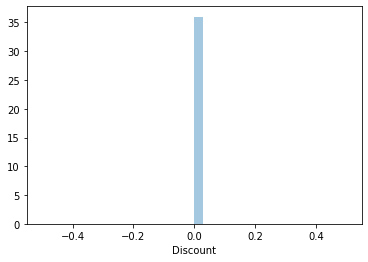

In [76]:
sns.distplot(grouped_no_discount)

In [29]:
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount is not 0
               """)
df_discount = pd.DataFrame(cur.fetchall())
df_discount.columns = [x[0] for x in cur.description]
df_discount

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.40,35,0.15
1,10250/65,10250,65,16.80,15,0.15
2,10251/22,10251,22,16.80,6,0.05
3,10251/57,10251,57,15.60,15,0.05
4,10252/20,10252,20,64.80,40,0.05
...,...,...,...,...,...,...
833,11077/39,11077,39,18.00,2,0.05
834,11077/46,11077,46,12.00,3,0.02
835,11077/60,11077,60,34.00,2,0.06
836,11077/64,11077,64,33.25,2,0.03


In [69]:
grouped_discount = df_discount.groupby(['OrderId', 'ProductId', 'Quantity'])['Discount'].sum()
grouped_discount

OrderId  ProductId  Quantity
10250    51         35          0.15
         65         15          0.15
10251    22         6           0.05
         57         15          0.05
10252    20         40          0.05
                                ... 
11077    39         2           0.05
         46         3           0.02
         60         2           0.06
         64         2           0.03
         73         2           0.01
Name: Discount, Length: 838, dtype: float64

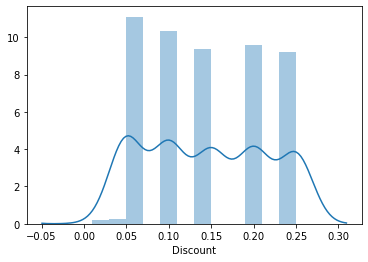

In [70]:
sns.distplot(grouped_discount)

2 Sample Two Test

In [77]:
alpha = 0.05
x_bar_no_discount = grouped_no_discount.mean()
x_bar_discount = grouped_discount.mean()
sigma_no_discount = grouped_no_discount.std()
sigma_discount = grouped_discount.std()
n_no_discount = len(grouped_no_discount)
n_discount = len(grouped_discount)
mu_discount = mu_no_discount = 100
dof = n_discount - 1
t = ((x_bar_no_discount-x_bar_discount) - (mu_no_discount-mu_discount)) / np.sqrt((sigma_no_discount**2/n_no_discount) + (sigma_discount**2/n_discount))
t

-58.22836992556129

In [78]:
stats.ttest_ind(grouped_no_discount, grouped_discount)

Ttest_indResult(statistic=-73.0067757091944, pvalue=0.0)

In [79]:
p_value = 0.0

In [80]:
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


Mann Whitney
Effect Size
Next Steps ANOVA for different discount sizes

ANOVA:
feature: discount
target: quantity
H0: quantity of order is not affected by discount size
HA: quantity of order is affected by discount size

In [95]:
cur.execute("""SELECT DISTINCT(Discount)
               FROM OrderDetail
               """)
df_distint_discount = pd.DataFrame(cur.fetchall())
df_distint_discount.columns = [x[0] for x in cur.description]
df_distint_discount['Discount']

0     0.00
1     0.15
2     0.05
3     0.20
4     0.25
5     0.10
6     0.02
7     0.03
8     0.04
9     0.06
10    0.01
Name: Discount, dtype: float64

In [90]:
df_discount_0 = df[df['Discount']==0]
df_discount_0

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.0
1,10248/42,10248,42,9.80,10,0.0
2,10248/72,10248,72,34.80,5,0.0
3,10249/14,10249,14,18.60,9,0.0
4,10249/51,10249,51,42.40,40,0.0
...,...,...,...,...,...,...
2147,11077/52,11077,52,7.00,2,0.0
2148,11077/55,11077,55,24.00,2,0.0
2151,11077/66,11077,66,17.00,1,0.0
2153,11077/75,11077,75,7.75,4,0.0


In [91]:
df_discount_0_01 = df[df['Discount']==0.01]
df_discount_0_01

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2152,11077/73,11077,73,15.0,2,0.01


In [97]:
df_discount_0_02 = df[df['Discount']==0.02]
df_discount_0_02

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2133,11077/6,11077,6,25.0,1,0.02
2146,11077/46,11077,46,12.0,3,0.02


In [99]:
df_discount_0_03 = df[df['Discount']==0.03]
df_discount_0_03

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2139,11077/14,11077,14,23.25,1,0.03
2140,11077/16,11077,16,17.45,2,0.03
2150,11077/64,11077,64,33.25,2,0.03


In [100]:
df_discount_0_04 = df[df['Discount']==0.04]
df_discount_0_04

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2141,11077/20,11077,20,81.0,1,0.04


In [101]:
df_discount_0_05 = df[df['Discount']==0.05]
df_discount_0_05

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
8,10251/22,10251,22,16.80,6,0.05
9,10251/57,10251,57,15.60,15,0.05
11,10252/20,10252,20,64.80,40,0.05
12,10252/33,10252,33,2.00,25,0.05
51,10266/12,10266,12,30.40,12,0.05
...,...,...,...,...,...,...
2116,11071/13,11071,13,6.00,10,0.05
2123,11074/16,11074,16,17.45,14,0.05
2134,11077/7,11077,7,30.00,1,0.05
2137,11077/12,11077,12,38.00,2,0.05


In [102]:
df_discount_0_06 = df[df['Discount']==0.06]
df_discount_0_06

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2149,11077/60,11077,60,34.0,2,0.06


In [103]:
df_discount_0_1 = df[df['Discount']==0.1]
df_discount_0_1

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
107,10288/54,10288,54,5.90,10,0.1
108,10288/68,10288,68,10.00,3,0.1
115,10291/13,10291,13,4.80,20,0.1
116,10291/44,10291,44,15.50,24,0.1
117,10291/51,10291,51,42.40,2,0.1
...,...,...,...,...,...,...
2095,11063/41,11063,41,9.65,30,0.1
2096,11064/17,11064,17,39.00,77,0.1
2098,11064/53,11064,53,32.80,25,0.1
2099,11064/55,11064,55,24.00,4,0.1


In [104]:
df_discount_0_15 = df[df['Discount']==0.15]
df_discount_0_15

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.40,35,0.15
7,10250/65,10250,65,16.80,15,0.15
17,10254/24,10254,24,3.60,15,0.15
18,10254/55,10254,55,19.20,21,0.15
48,10264/41,10264,41,7.70,25,0.15
...,...,...,...,...,...,...
2112,11070/2,11070,2,19.00,20,0.15
2113,11070/16,11070,16,17.45,30,0.15
2124,11075/2,11075,2,19.00,10,0.15
2125,11075/46,11075,46,12.00,30,0.15


In [106]:
df_discount_0_2 = df[df['Discount']==0.2]
df_discount_0_2

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
29,10258/2,10258,2,15.20,50,0.2
30,10258/5,10258,5,17.00,65,0.2
31,10258/32,10258,32,25.60,6,0.2
40,10262/5,10262,5,17.00,12,0.2
99,10285/1,10285,1,14.40,45,0.2
...,...,...,...,...,...,...
2069,11053/18,11053,18,62.50,35,0.2
2071,11053/64,11053,64,33.25,25,0.2
2091,11062/53,11062,53,32.80,10,0.2
2092,11062/70,11062,70,15.00,12,0.2


In [107]:
df_discount_0_25 = df[df['Discount']==0.25]
df_discount_0_25

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
34,10260/41,10260,41,7.70,16,0.25
36,10260/62,10260,62,39.40,15,0.25
37,10260/70,10260,70,12.00,21,0.25
43,10263/16,10263,16,13.90,60,0.25
45,10263/30,10263,30,20.70,60,0.25
...,...,...,...,...,...,...
2101,11065/30,11065,30,25.89,4,0.25
2102,11065/54,11065,54,7.45,20,0.25
2127,11076/6,11076,6,25.00,20,0.25
2128,11076/14,11076,14,23.25,20,0.25


In [109]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
sm.stats.anova_lm(ols('Quantity ~ Discount', data=df).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,12884.989179,12884.989179,36.191587,2.095888e-09
Residual,2153.0,766514.647015,356.021666,NaN,NaN


In [115]:
anova_df = df_drop[df_drop['Discount']!=0]
anova_df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.40,35,0.15
7,10250/65,10250,65,16.80,15,0.15
8,10251/22,10251,22,16.80,6,0.05
9,10251/57,10251,57,15.60,15,0.05
11,10252/20,10252,20,64.80,40,0.05
...,...,...,...,...,...,...
2125,11075/46,11075,46,12.00,30,0.15
2126,11075/76,11075,76,18.00,2,0.15
2127,11076/6,11076,6,25.00,20,0.25
2128,11076/14,11076,14,23.25,20,0.25


In [116]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
sm.stats.anova_lm(ols('Quantity ~ Discount', data=anova_df).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,18.503014,18.503014,0.043107,0.835576
Residual,823.0,353261.492138,429.236321,NaN,NaN


In [119]:
p_value = 0.835576
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


quantity of order is not affected by discount size